# LikesLearning

## Applying Cognitive Services and Machine Learning to Discover Photo Likability on Instagram

You may have wondered - what makes a good Instagram photo, which recives big number of likes from you followers? In this demo, we will try to answer this question using Data Science!

I will take my own Instagram ([@shwars](http://instagram.com/shwars)) as an example, and I encourage you to do the same with yours. You are likely to get slightly different results, because subscribed audiences differ, and some of the findings might surprise you!

So, what I have done prior to this demo:

1. Download all your content from Instagram. You may find instructions [here](https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/#:~:text=It%27s%20easy%20to%20download%20all,data%20using%20the%20web%20version.&text=Go%20to%20instagram.com.,Scroll%20down%20to%20Data%20Download.)
1. Because Instagram does not provide number of likes for each photo, you may need either to write scraping code to get that from the web, or manually collect number of likes. I did the latter.
1. At the end, I came up with the dataset, which consists of the following:
   - [JSON file](data/instagram_shwars.jsondata/instagram_shwars.json) with all the metadata
   - Actual pictures uploaded to the Azure Blob Storage, which are available at the URL specified by `photo_storage`:

In [2]:
json_file = 'data/instagram_shwars.json'
photo_storage = "https://instagramdataset.blob.core.windows.net/shwars/"

Let's start by importing some of the required libraries.

In [3]:
import sys, os
import json
import pandas as pd
import matplotlib.pyplot as plt
import functools

Now let's load JSON file and see how it looks like:

In [4]:
with open(json_file, encoding='utf-8') as f:
    data = json.load(f)

In [5]:
data[0]

{'taken_at': '2020-07-01 10:56:38+00:00',
 'caption': 'Всем привет! За несколько месяцев вынужденной изоляции существенно возросло количество фотографий еды в моём телефоне. Чтобы не утомлять своих подписчиков большим количеством еды, и при этом не испытывать муки совести от того, что публикую не слишком интересный контент, я решил использовать для еды отдельный аккаунт @how.tasty. Подписывайтесь, если хотите поднимать аппетит фотографиями аппетитных блюд, иногда с рецептами...\n#food #foodporn #foodphotography #cooking #amateurchef #foodphoto #foodie',
 'path': ['202007_b183670c4a31d853441d05d9e2600828.jpg'],
 'likes': '20'}

To make it easier to work with this file, we will convert it to Pandas Dataframe, and also take care of some of the data conversion:

In [6]:
df = pd.DataFrame(data)
df['taken_at'] = pd.to_datetime(df['taken_at'],errors='raise')
start_date = df['taken_at'].min()
df['days'] = df['taken_at'].apply(lambda x: (x-start_date).days)
df['likes'] = df['likes'].astype(int)
df.dtypes

taken_at    datetime64[ns, UTC]
caption                  object
path                     object
likes                     int32
days                      int64
dtype: object

In [7]:
df

,taken_at,caption,path,likes,days
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887
...,...,...,...,...,...
1035,2018-01-09 05:40:38+00:00,В раздевалке...,[201801_84788221c4213fb032f9076162be4ad5.jpg],46,1
1036,2018-01-08 23:33:10+00:00,Геометрия сосисочного шашлыка в детском лагере...,[201801_ccc3144c9aeb304eddf4810318c61390.jpg],33,1
1037,2018-01-07 21:35:26+00:00,Компьютерный класс готовится принять детей - а...,[201801_f499543f9e3379a0a0ca44527ce27709.jpg],33,0
1038,2018-01-07 21:32:58+00:00,"Зимняя #компьютерия, или немного предзакатного...",[201801_42cb11c0fc018a768cfccbfa036c0a2d.jpg],47,0


## Exploring the Data

Now that we have the data - let's start exploring! First of all, let's just plot the number of likes:

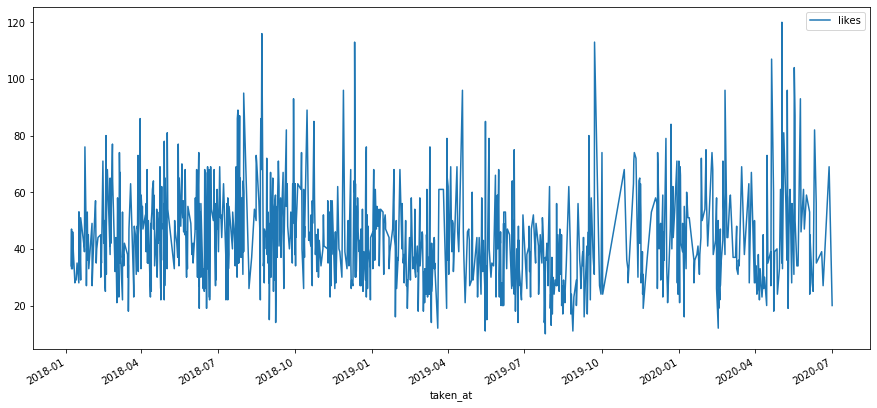

In [8]:
df.plot('taken_at','likes',figsize=(15,7))

From this plot, it is not very obvious how the number of likes changes with time. To make it easier to grasp, we can compute the running average over this data - let's say, with the window of 10,20,30 and 60 posts:

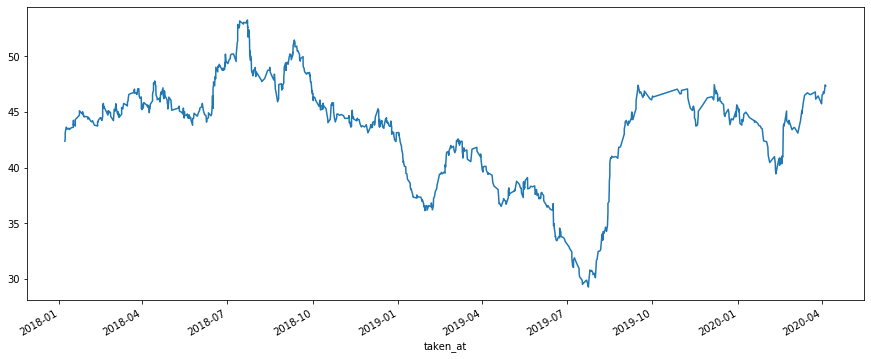

In [9]:
df.set_index('taken_at')['likes'].rolling(window=60).mean().plot(figsize=(15,6))

It would also be interesting to have a look at the average number of likes by month:

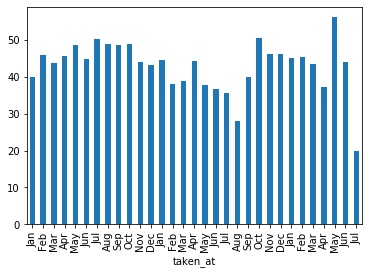

In [10]:
dff = df.set_index('taken_at').groupby(pd.Grouper(freq='M'))['likes'].mean()
ax = dff.plot(kind='bar')
x_labels = dff.index.strftime('%b')
ax.set_xticklabels(x_labels)
plt.show()

Another dependency we may want to explore is how likes depend on the number of pictures in the post.

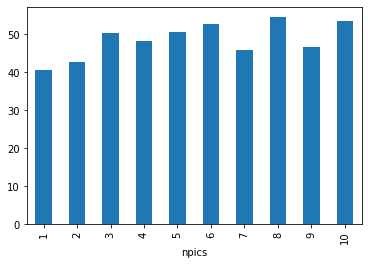

In [11]:
df['npics'] = df['path'].apply(len)
df.groupby('npics')['likes'].mean().plot(kind='bar')

## Learning with Tags

It would be logical to assume that tags affect photo likability. To discover that, let's extract tags from description using regular expressions:

In [12]:
df['tags'] = df['caption'].str.findall(r'#.*?(?=\s|$)')
df

,taken_at,caption,path,likes,days,npics,tags
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905,1,"[#food, #foodporn, #foodphotography, #cooking,..."
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902,3,"[#sunset, #sunsetporn]"
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895,2,[]
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893,5,[]
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887,1,[]
...,...,...,...,...,...,...,...
1035,2018-01-09 05:40:38+00:00,В раздевалке...,[201801_84788221c4213fb032f9076162be4ad5.jpg],46,1,1,[]
1036,2018-01-08 23:33:10+00:00,Геометрия сосисочного шашлыка в детском лагере...,[201801_ccc3144c9aeb304eddf4810318c61390.jpg],33,1,1,"[#junio-r, #bestcamp, #geometryof]"
1037,2018-01-07 21:35:26+00:00,Компьютерный класс готовится принять детей - а...,[201801_f499543f9e3379a0a0ca44527ce27709.jpg],33,0,1,[#minecraftedu]
1038,2018-01-07 21:32:58+00:00,"Зимняя #компьютерия, или немного предзакатного...",[201801_42cb11c0fc018a768cfccbfa036c0a2d.jpg],47,0,1,"[#компьютерия,]"


The most obvious dependency is on the number of likes. We would assume that if a picture has more tags - it probably has move likes, because additional audience is attracted to it.

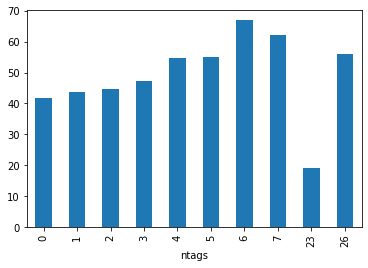

In [13]:
df['ntags'] = df['tags'].apply(len)
df.groupby('ntags')['likes'].mean().plot(kind='bar')

Now let's discover most frequent tags and analyze their performance individually. To do that, we will compute average # of likes for pictures that contain different tags:

In [14]:
def freq(l,threshold=0):
    d = {}
    for x in l:
        d[x] = d.get(x,0)+1
    return { k:v for k,v in d.items() if v>threshold }

freq(df['tags'].sum(),10)

{'#sunset': 17,
 '#geometryof': 191,
 '#quarantine': 15,
 '#quarantinelife': 12,
 '#urbansunset': 12,
 '#будниевангелиста': 78,
 '#shwarsustrip': 15,
 '#imaginecup': 14,
 '#imcup': 13}

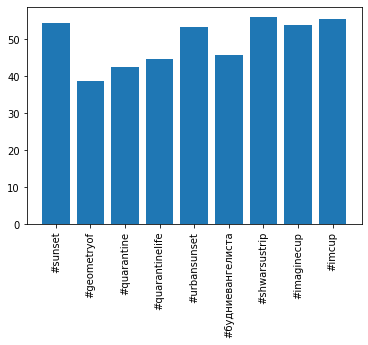

In [15]:
tags = freq(df['tags'].sum(),10).keys()
tag_likes = [df[df['tags'].apply(lambda x: t in x)]['likes'].mean() for t in tags]
plt.bar(x=tags,height=tag_likes)
plt.xticks(rotation=90)
plt.show()

## Analyzing Contents of Pictures

Instagram is all about visual content, and people like pictures because they find them visually appealling. Let's try to extract some meaningful features from pictures by analyzing them using [Cognitive Services Computer Vision API](https://docs.microsoft.com/azure/cognitive-services/computer-vision/?WT.mc_id=ca-6956-dmitryso)

First, we need to make sure that Python Computer Vision SDK is installed. If you want to read more docs on Computer Vision - [here they are](https://docs.microsoft.com/azure/cognitive-services/computer-vision/quickstarts-sdk/client-library?pivots=programming-language-python&WT.mc_id=ca-6956-dmitryso)

In [42]:
!{sys.executable} -m pip install azure-cognitiveservices-vision-computervision

To make Computer Vision calls, we need **key** and **endpoint URL**. They can be obtained in one of the following ways:
* If you have an Azure Subscription, [create Computer Vision resource](https://portal.azure.com/#create/Microsoft.CognitiveServicesComputerVisionhttps://portal.azure.com/#create/Microsoft.CognitiveServicesComputerVision) and take values from there
* If you do not have a subscription - get [free trial](https://azure.microsoft.com/free/?WT.mc_id=ca-6956-dmitryso), or [free student trial](https://azure.microsoft.com/en-us/free/students/?WT.mc_id=ca-6956-dmitryso)
* If you just want to try things once - [get trial key here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=computer-vision&WT.mc_id=ca-6956-dmitryso) (which is valid for a week) 

Once you get that data - create a file called `keys.json` in the current directory, putting your data there. You can use the following cell as an example, or copy provided `keys_sample.json`.

In [58]:
%%writefile keys.json
{
    "endpoint": "https://--region--.api.cognitive.microsoft.com/",
    "key": "---your key here---"
}

Writing keys1.json


In [14]:
with open('keys.json','r') as f:
    keys = json.load(f)

Data from photographs can be analyzed with just one call to the `ComputerVisionClient` object, which we create here:

In [15]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

credentials = CognitiveServicesCredentials(keys['key'])
client = ComputerVisionClient(
    endpoint=keys['endpoint'],
    credentials=credentials
)

client.analyze_image('https://soshnikov.com/images/official/shwars_casual.jpg',visual_features=[VisualFeatureTypes.faces]).as_dict()

{'faces': [{'age': 42,
   'gender': 'Male',
   'face_rectangle': {'left': 483, 'top': 234, 'width': 298, 'height': 298}}],
 'request_id': '15f139cd-7691-49f4-b3c6-d806631e093f',
 'metadata': {'width': 1271, 'height': 847, 'format': 'Jpeg'}}

In [16]:
def analyze(fn):
    return client.analyze_image(photo_storage + fn,visual_features=
      [VisualFeatureTypes.categories, VisualFeatureTypes.faces,
       VisualFeatureTypes.tags, VisualFeatureTypes.color, VisualFeatureTypes.adult,
       VisualFeatureTypes.description, VisualFeatureTypes.objects]).as_dict()

analyze(data[4]['path'][0])

{'categories': [{'name': 'people_portrait',
   'score': 0.64453125,
   'detail': {'celebrities': [{'name': 'Dmitri Soshnikov',
      'confidence': 0.9986395239830017,
      'face_rectangle': {'left': 410,
       'top': 593,
       'width': 408,
       'height': 408}}]}}],
 'adult': {'is_adult_content': True,
  'is_racy_content': True,
  'is_gory_content': False,
  'adult_score': 0.8249362111091614,
  'racy_score': 0.8336015343666077,
  'gore_score': 0.04116944968700409},
 'color': {'dominant_color_foreground': 'Brown',
  'dominant_color_background': 'Brown',
  'dominant_colors': ['Brown', 'Black', 'White'],
  'accent_color': '7E754D',
  'is_bw_img': False},
 'tags': [{'name': 'person', 'confidence': 0.9993911981582642},
  {'name': 'man', 'confidence': 0.998226523399353},
  {'name': 'indoor', 'confidence': 0.945901095867157},
  {'name': 'human face', 'confidence': 0.9311392307281494},
  {'name': 'selfie', 'confidence': 0.906960129737854},
  {'name': 'human beard', 'confidence': 0.863548

Now we need to analyze all photographs in our dataset! There are a few problems which we may face:
* Some pictures are videos, which are not present in the dataset. We need to make sure that if image is not found - it is just skipped. We implement `safe_map` function, similar to `map`, but ignoring errors.
* Free tier of Computer Vision allows only 20 calls per minute. If you are on the free tier, and want to analyze all pictures - insert a delay into `analyze` function, and keep the process running overnight.

In [53]:
def safe_map(seq,f):
    for x in seq:
        try:
            yield f(x)
        except Exception as e:
            print(" - Error: {}".format(e))

def safe_mapl(seq,f):
    return list(safe_map(seq,f))

df['cognitive'] = df['path'].apply(functools.partial(safe_mapl,f=analyze))
df.head()

- Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not

,taken_at,caption,path,likes,days,tags,npics,cognitive
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905,"[#food, #foodporn, #foodphotography, #cooking,...",1,"[{'categories': [{'name': 'people_', 'score': ..."
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902,"[#sunset, #sunsetporn]",3,"[{'categories': [{'name': 'sky_cloud', 'score'..."
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895,[],2,"[{'categories': [{'name': 'drink_', 'score': 0..."
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893,[],5,"[{'categories': [{'name': 'food_', 'score': 0...."
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887,[],1,"[{'categories': [{'name': 'people_portrait', '..."


Once we have the data - we save the file into pickled version, so that we do not have to go through the same process again.

In [56]:
os.makedirs('temp',exist_ok=True)
df.to_pickle('temp/data.pkl')

In [16]:
df = pd.read_pickle('temp/data.pkl')

Now let's extract some useful features from the JSON data. We have either one, or a set of pictures corresponding to each post, so we need to aggregate accross several pictures sometimes. This can be done is multiple ways, here is what we will extract:
* Average age of all faces on all pictures
* Average gender (considering 1 for male, -1 for female).
* Presence of male and female pictures


In [18]:
def mean(l):
    if len(l)==0:
        return 0
    else:
        return sum(l)/len(l)

def process_result(ar):
    faces = sum([x['faces'] for x in ar],[])
    categs = sum([x['categories'] for x in ar],[])
    categs.sort(key=lambda x: x['score'],reverse=True) 
    tags = sum([x['tags'] for x in ar],[])
    age_list = [1 if x['gender']=='Male' else -1 for x in faces]
    safe = lambda z: "" if len(z)==0 else z[0]['text']
    return {
        "category" : categs[0]['name'] if len(categs)>0 else "",
        "categories" : set(x['name'] for x in categs),
        "foreground_colors": set(x['color']['dominant_color_foreground'] for x in ar),
        "background_colors": set(x['color']['dominant_color_foreground'] for x in ar),
        "nfaces" : len(faces),
        "age" : mean([x['age'] for x in faces]),
        "gender" : mean(age_list),
        "vtags" : set(x['name'] for x in tags),
        "description" : ".".join([safe(x['description']['captions']) for x in ar]),
        "adult_score" : mean([x['adult']['adult_score'] for x in ar])
    }

process_result(df['cognitive'][4])

{'category': 'people_portrait',
 'categories': {'people_portrait'},
 'foreground_colors': {'Brown'},
 'background_colors': {'Brown'},
 'nfaces': 1,
 'age': 45.0,
 'gender': 1.0,
 'vtags': {'beard',
  'clothing',
  'human beard',
  'human face',
  'indoor',
  'man',
  'moustache',
  'person',
  'selfie'},
 'description': 'Dmitri Soshnikov looking at the camera',
 'adult_score': 0.8249362111091614}

Now let's add all the processing results into the same frame:

In [19]:
df = df.join(df['cognitive'].apply(lambda x: pd.Series(process_result(x))))

In [20]:
df.iloc[0]

taken_at                                     2020-07-01 10:56:38+00:00
caption              Всем привет! За несколько месяцев вынужденной ...
path                     [202007_b183670c4a31d853441d05d9e2600828.jpg]
likes                                                               20
days                                                               905
tags                 [#food, #foodporn, #foodphotography, #cooking,...
npics                                                                1
cognitive            [{'categories': [{'name': 'people_', 'score': ...
category                                                       people_
categories                                                   {people_}
foreground_colors                                               {Grey}
background_colors                                               {Grey}
nfaces                                                               0
age                                                                  0
gender

## Simple Conclusions

Let's first see if we can find some easy dependencies from this data:

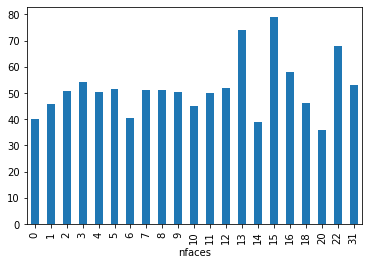

In [21]:
df.groupby('nfaces')['likes'].mean().plot(kind='bar')

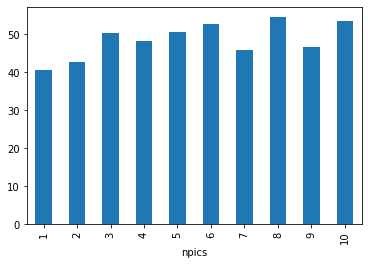

In [22]:
df.groupby('npics')['likes'].mean().plot(kind='bar')

Посмотрим на зависимость от пола и возраста:

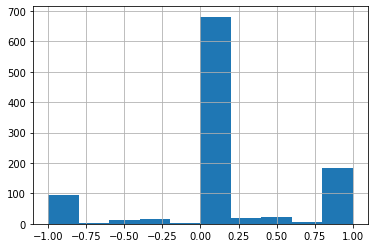

In [23]:
df["gender"].hist()

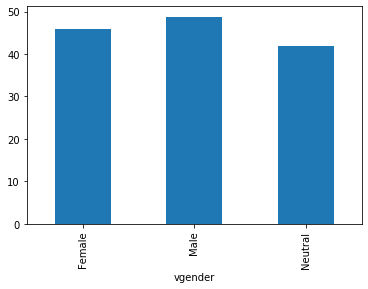

In [25]:
def verbal_gender(x):
    if x< -0.5: return "Female"
    elif x>0.5: return "Male"
    else: return "Neutral"

df["vgender"] = df["gender"].apply(verbal_gender)

df.groupby('vgender')['likes'].mean().plot(kind='bar')

In [26]:
df[df['age']>0]['age'].describe()

count    416.000000
mean      34.586762
std       11.897461
min        4.000000
25%       26.390152
50%       34.906250
75%       44.000000
max       68.000000
Name: age, dtype: float64

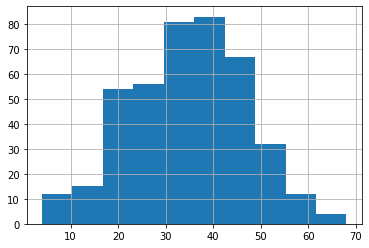

In [27]:
df[df['age']>0]['age'].hist()

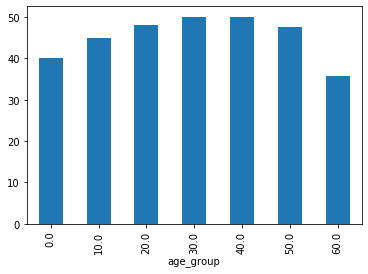

In [28]:
df['age_group'] = df['age']//10*10
df.groupby('age_group')['likes'].mean().plot(kind='bar')

## See the Effect of Categories and Tags

The most interesting thing is to try to see how main category affects likability. To estimate that, we will explore most popular categories:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

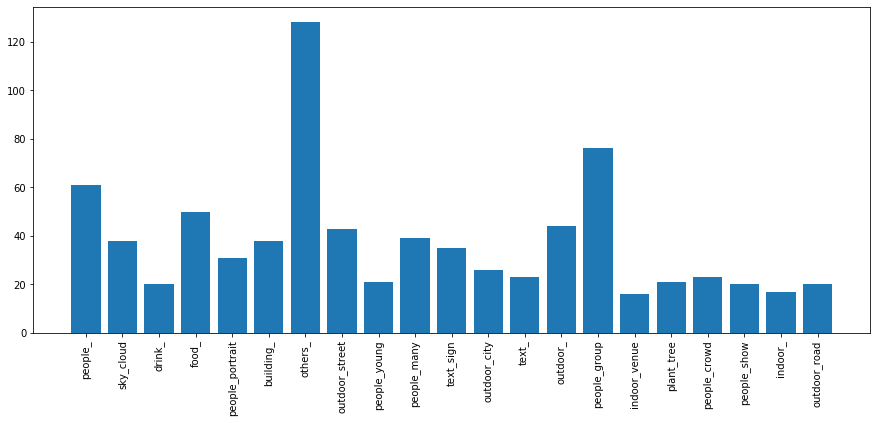

In [48]:
df['category'] = df['category'].apply(lambda x: 'others_' if x=='' else x)
freq_categs = freq(df['category'],15)
plt.figure(figsize=(15,6))
plt.bar(x=freq_categs.keys(),height=freq_categs.values())
plt.xticks(rotation=90)

For each category from this list, we will compute mean likes:

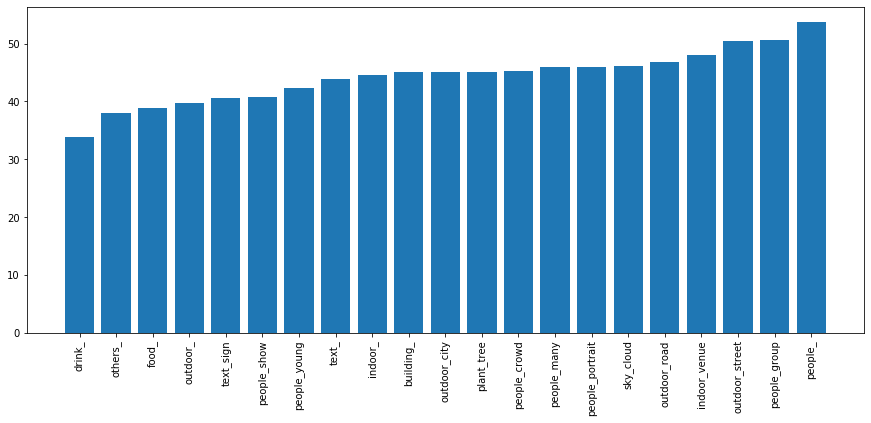

In [51]:
def tplot(x,y):
    z = list(zip(x,y))
    z.sort(key=lambda x: x[1])
    x,y = zip(*z)
    plt.figure(figsize=(15,6))
    plt.bar(x=x,height=y)
    plt.xticks(rotation=90)
    plt.show()

cat_likes = [df[df['category']==c]['likes'].mean() for c in freq_categs]
tplot(freq_categs,cat_likes)

Let's do the same process with tags:

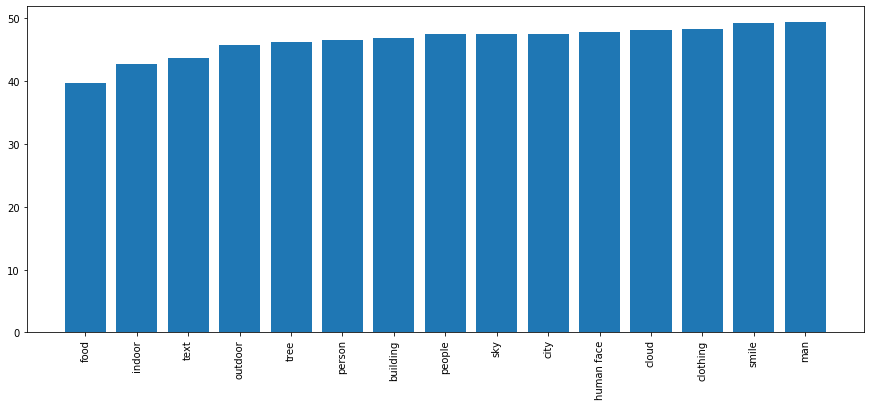

In [53]:
freq_tags = freq(sum(df['vtags'].apply(list),[]),150).keys()
tag_likes = [df[df['vtags'].apply(lambda x: t in x)]['likes'].mean() for t in freq_tags]
tplot(freq_tags,tag_likes)

We can also compare some selected tags. For example, let's find out who is more popular - cats or dogs? (and we will also include people of different kinds)

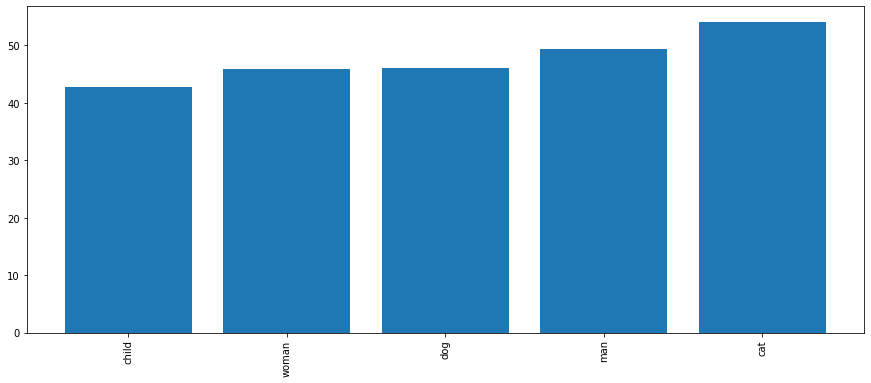

In [56]:
def plot_tags(tags):
    tag_likes = [df[df['vtags'].apply(lambda x: t in x)]['likes'].mean() for t in tags]
    tplot(tags,tag_likes)

plot_tags(['cat','dog','child','man','woman'])

## Using Machine Learning

We can use machine learning and `sklearn` library to try training predictive model that will estimate number of likes for a picture. We can also try to make this model **interpretable**, to see which features play more important role.

In [58]:
import sklearn
import sklearn.neighbors
import sklearn.tree
import sklearn.neural_network
import sklearn
import sklearn.neighbors
import sklearn.tree
import sklearn.neural_network

fields = ['days','npics','gender','age']
X = df[fields]
Y = df['likes']

model = sklearn.linear_model.LinearRegression()
model.fit(X,Y)
list(zip(fields,model.coef_))

[('days', -0.007779496893308267),
 ('npics', 1.8995465819335595),
 ('gender', 0.21720693301993926),
 ('age', 0.2014120410627087)]

In [70]:
def test_model(X,Y,model):
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    print("MAE: {}".format(sklearn.metrics.mean_absolute_error(Y_test,Y_pred)))
    return model

test_model(X,Y,sklearn.linear_model.LinearRegression())
test_model(X,Y,sklearn.neighbors.KNeighborsRegressor())
test_model(X,Y,sklearn.tree.DecisionTreeRegressor())
test_model(X,Y,sklearn.neural_network.MLPRegressor())
test_model(X,Y,sklearn.linear_model.BayesianRidge())
test_model(X,Y,sklearn.svm.SVR())

MAE: 11.12062013130611
MAE: 12.84
MAE: 14.146153846153846
MAE: 13.284838910106226
MAE: 11.335304143799604
MAE: 12.663598518978027


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [60]:
avg = df['likes'].mean()
sklearn.metrics.mean_absolute_error(df['likes'],[avg]*len(df))

12.668759245562132

In [61]:
tags_df = df['vtags'].apply(lambda x: pd.Series([1 if z in x else 0 for z in freq_tags]))
tags_df.columns=freq_tags
tags_df

,indoor,food,person,cloud,building,outdoor,city,sky,human face,clothing,man,smile,text,tree,people
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0
1036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1037,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1038,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0


MAE: 12.471785518948622


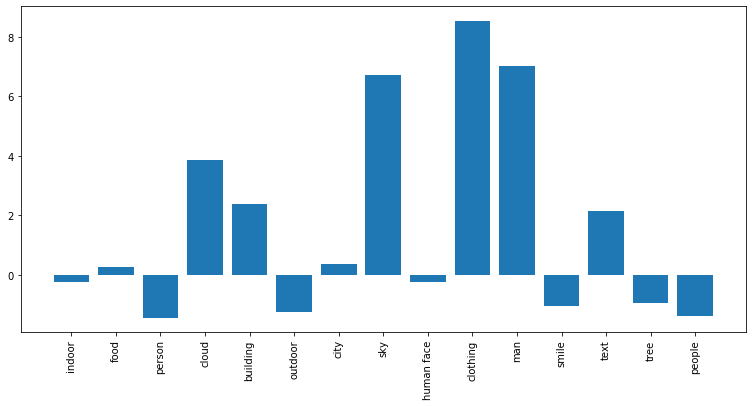

In [62]:
X = tags_df
Y = df['likes']
model = test_model(X,Y,sklearn.linear_model.LinearRegression())
plt.figure(figsize=(13,6))
plt.bar(X.columns,height=model.coef_)
plt.xticks(rotation=90)
plt.show()

In [65]:
categ_df = df['category'].apply(lambda x: pd.Series([1 if z == x else 0 for z in freq_categs]))
categ_df.columns=freq_categs
categ_df


,people_,sky_cloud,drink_,food_,people_portrait,building_,others_,outdoor_street,people_young,people_many,...,outdoor_city,text_,outdoor_,people_group,indoor_venue,plant_tree,people_crowd,people_show,indoor_,outdoor_road
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


MAE: 11.465433567160739


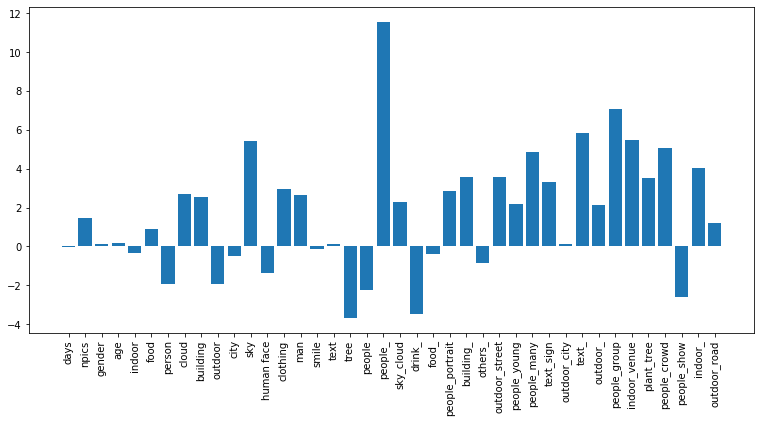

tree -> -3.692776489118748
drink_ -> -3.4830271981282164
people_show -> -2.603907973490456
people -> -2.2347738604968783
person -> -1.9339454639376872
outdoor -> -1.9319810575086862
human face -> -1.347220653120447
others_ -> -0.8359284452597375
city -> -0.5000356933172498
food_ -> -0.41598074411845215
indoor -> -0.3409653080495966
smile -> -0.11617963729065141
days -> -0.006197323581478961
gender -> 0.09889765090371211
outdoor_city -> 0.11651582998889123
text -> 0.11921158159141505
age -> 0.15562433142313487
food -> 0.9207956950135565
outdoor_road -> 1.185431566813916
npics -> 1.4452727178620681
outdoor_ -> 2.148704525433626
people_young -> 2.1885270034634927
sky_cloud -> 2.2892589698297208
building -> 2.535692112434624
man -> 2.6680038684081473
cloud -> 2.706209725710535
people_portrait -> 2.856332279978581
clothing -> 2.9585028222401837
text_sign -> 3.332995488245558
plant_tree -> 3.5208521800976507
outdoor_street -> 3.5503647504375646
building_ -> 3.597756504580742
indoor_ -> 4.037

In [69]:
joint_df = df[fields].join(tags_df).join(categ_df)
X = joint_df
Y = df['likes']
model = test_model(X,Y,sklearn.linear_model.LinearRegression())
plt.figure(figsize=(13,6))
plt.bar(X.columns,height=model.coef_)
plt.xticks(rotation=90)
plt.show()
for k,v in sorted(zip(joint_df.columns,model.coef_),key=lambda x:x[1]):
    print("{} -> {}".format(k,v))


This brings us to the nice conclusion, that people do not like drinking, but they like looking at other people.


## Some Final Pictures

There are many more things that can be investigated, but we will finish here. To conclude, let's plot the word cloud of photo descriptions:

In [71]:
!{sys.executable} -m pip install wordcloud

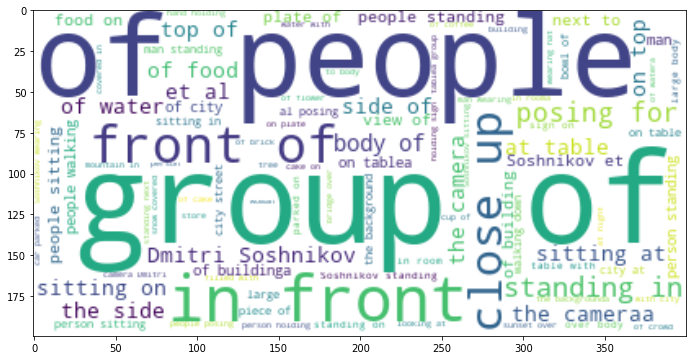

In [97]:
import wordcloud

def wcloud(txt):
    stopwords = set(wordcloud.STOPWORDS)
    set.update(set(['на','по','что','или','не','Из','по','что','ещё','как']))
    wc = wordcloud.WordCloud(background_color='white').generate(txt)
    plt.figure(figsize=(13,6))
    plt.imshow(wc,interpolation='bilinear')

wcloud(df['description'].sum())

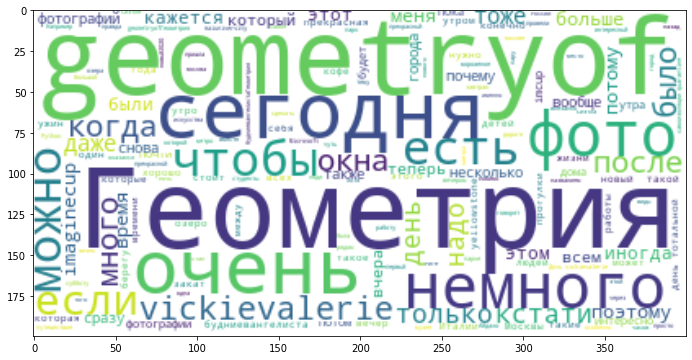

In [99]:
import re
shortword = re.compile(r'\W*\b\w{1,3}\b')
wcloud(shortword.sub('',df['caption'].sum()))